In [1]:
import numpy as np
import random as rnd
import os
import re
from IPython.display import HTML, display
import matplotlib.pyplot as plt

In [2]:
# log files can be downloaded from 
# https://github.com/SINTEF-9012/thingml-diversifier/releases/download/1.0.0-alpha/experiments1-logs.zip

languages = ['java', 'nodejs', 'go']
modes = ['base', 'static', 'dynamic']
fig_counter = 0
root='../../../../../experiments1-logs/thingml-bytes-logs'
models='../../../../../experiments1-models/thingml-bytes-models'
sources='../../../../../experiments1-generated-code/thingml-bytes-platform'

In [3]:
def allFiles(language, mode, log):
    directory = os.fsencode(root + '/' + language + '/' + mode)
    for file in os.listdir(directory):
        filename = root + '/' + language + '/' + mode + '/' + os.fsdecode(file)
        if log:            
            if filename.split('/')[-1].startswith('nolog'+language) and filename.endswith('.log'): 
                yield filename
        else:
            if filename.split('/')[-1].startswith(language) and filename.endswith('.log'): 
                yield filename

def loadTimestamps(filename):
    file = open(filename)
    score = -1
    while True:
        line = file.readline()      
        if not line:
            if score != 349:
                print('In ' + filename + ' : final score should be 349. Was ' + str(score))
            break        
        if line.startswith('ts:'):
            ts = int(line[1:].strip().split(',')[0].split(':')[1:][0])
            score = int(line[1:].strip().split(',')[2].split(':')[1:][0])
            yield ts  
            
def loadMemory(filename):
    file = open(filename)
    while True:
        line = file.readline()      
        if not line:
            break        
        if line.startswith('#usedMem:'):
            mem = int(line[1:].strip().split(':')[1:][0])
            yield mem   
            
def loadTotalTime(filename):
    file = open(filename)
    while True:
        line = file.readline()      
        if not line:
            break        
        if line.startswith('>done in '):
            time = line[9:-4].strip()
            return int(time)              

In [4]:
def allData(language, mode):
    all_ts = []
    all_mem = []
    all_t = []
    for filename in allFiles(language, mode, True):
        ts = np.array(list(loadTimestamps(filename))).astype(int)
        mem = np.array(list(loadMemory(filename))).astype(int).flatten()
        t = loadTotalTime(filename)
        all_ts.append(ts)
        all_mem.append(mem)
        all_t.append(t)
    return all_ts, all_mem, all_t

In [5]:
def color(mode, alpha):
    if mode == 'base':
        return 0.2, 0.9, 0.35, alpha
    elif mode == 'static':
        return 0.35, 0.2, 0.9, alpha
    elif mode == 'dynamic':
        return 0.9, 0.35, 0.2, alpha
    
def grey(mode):
    alpha = 0.25
    if mode == 'base':
        return 0.75, 1, 0.9, alpha
    elif mode == 'static':
        return 0.9, 0.75, 1, alpha
    elif mode == 'dynamic':
        return 1, 0.9, 0.75, alpha

def bounds(mode, ts):
    if mode == 'base':
        return [0, len(ts)/6]
    elif mode == 'static':
        return [len(ts)/2-len(ts)/12, len(ts)/2+len(ts)/12]
    elif mode == 'dynamic':
        return [len(ts) - len(ts)/6, len(ts)-1]

def plotTS(ts, language, mode):
    c = color(mode,1)
    fig.suptitle('Timestamps ' + language, fontsize=14)
    for s in ts:                
        plt.plot(s, color=grey(mode), zorder=0)
    avg = []
    for i in range(0, np.array(ts).shape[1]):
        avg.append(np.mean(np.array(ts)[:, i]))
    plt.plot(avg, color=c, linewidth=4, zorder=1)
    mean = np.mean(np.array(ts))
    std = np.std(np.array(ts))
    plt.plot(bounds(mode, ts[0]), [mean-std, mean+std], linewidth=8, color='black', ls='dotted', zorder=2)
    
def plotMem(ts, language, mode):
    c = color(mode,1)
    fig.suptitle('Memory ' + language, fontsize=14)
    for s in ts:                
        plt.plot(s, color=grey(mode), zorder=0)
    avg = []
    for i in range(0, np.array(ts).shape[1]):
        avg.append(np.mean(np.array(ts)[:, i]))
    plt.plot(avg, color=c, linewidth=4, zorder=1)
    mean = np.mean(np.array(ts).flatten())
    std = np.std(np.array(ts))
    plt.plot(bounds(mode, ts[0]), [mean-std, mean+std], linewidth=8, color='black', ls='dotted', zorder=2)      
    
def plotT(t, language, mode):
    c = color(mode,1)
    fig.suptitle('Execution time ' + language, fontsize=14)
    plt.plot(t, color=c, linewidth=4, zorder=0)
    mean = np.mean(np.array(t).flatten())
    std = np.mean(np.array(t).flatten())
    plt.plot(bounds(mode, t), [mean-std, mean+std], linewidth=8, color='black', ls='dotted', zorder=1)       

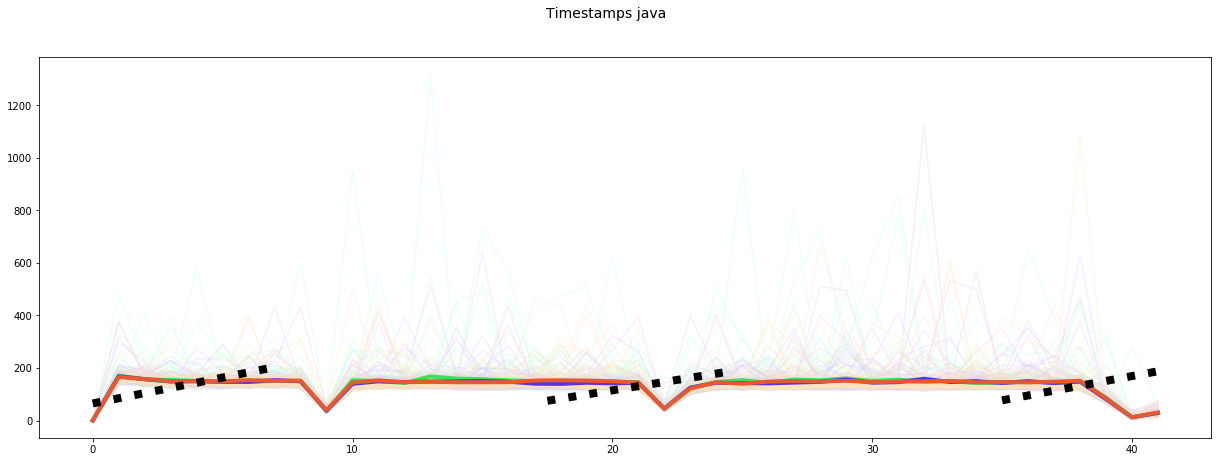

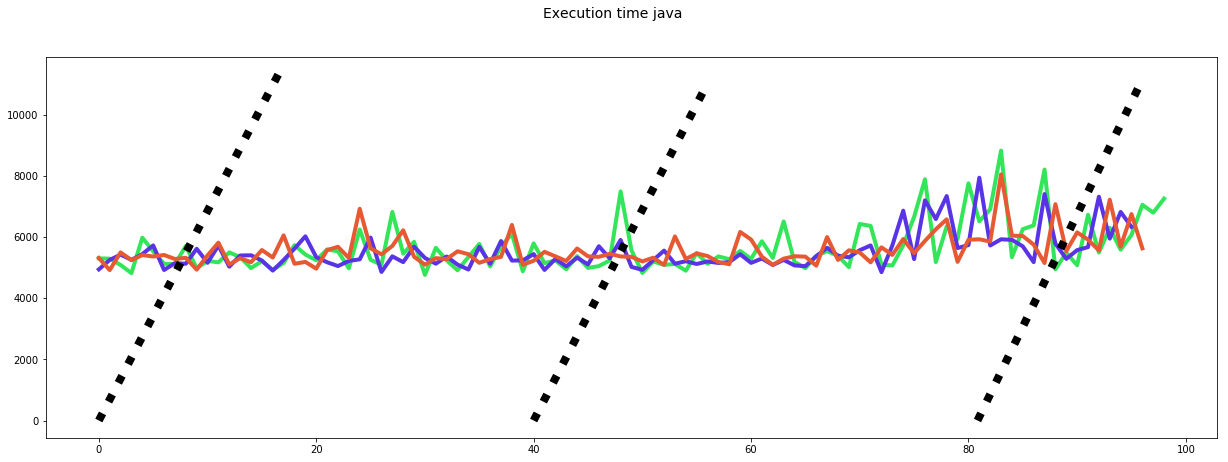

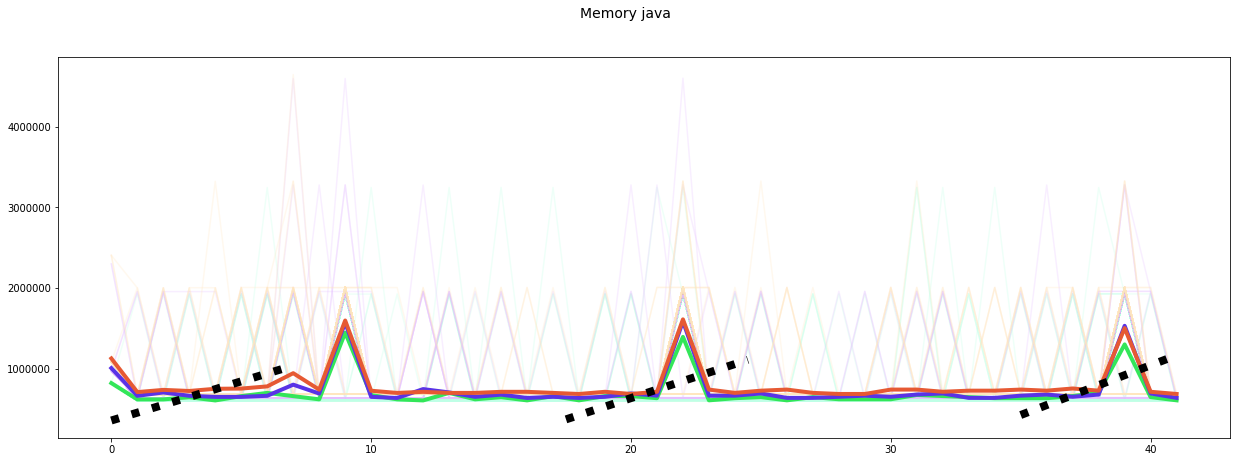

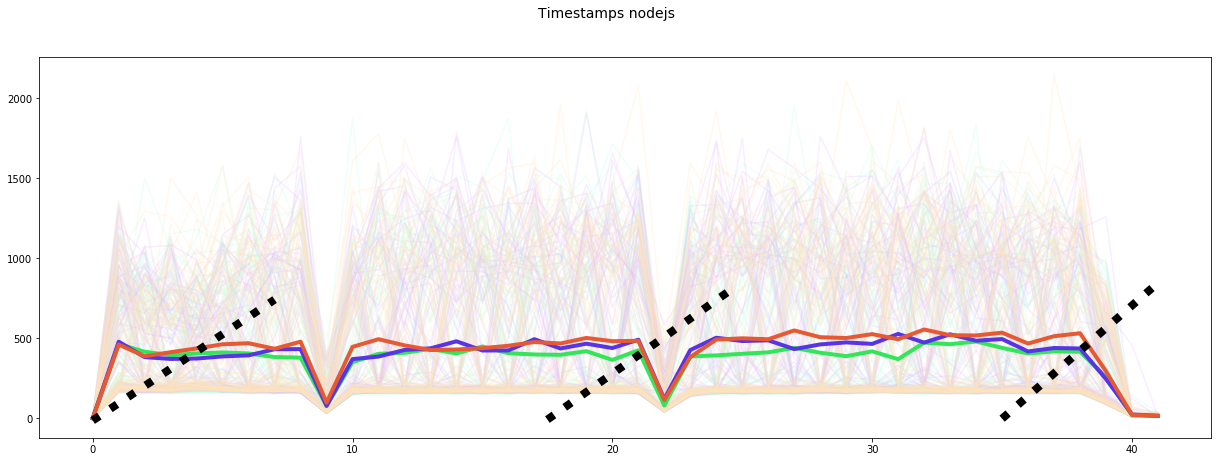

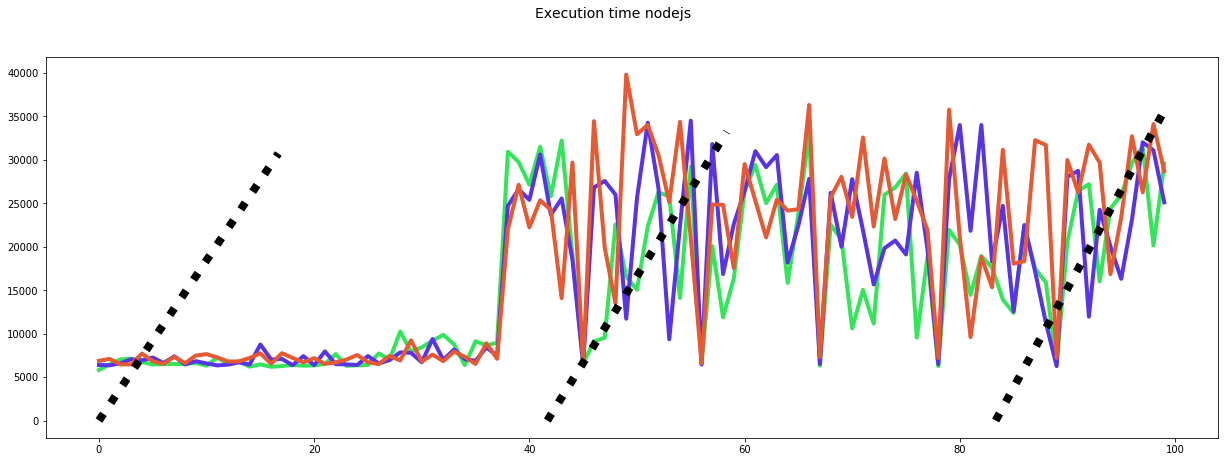

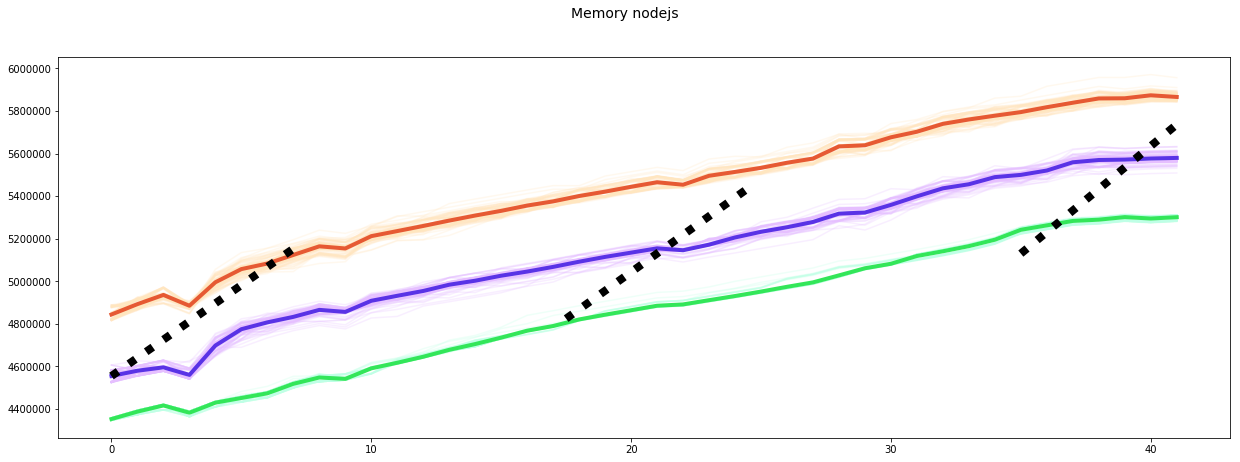

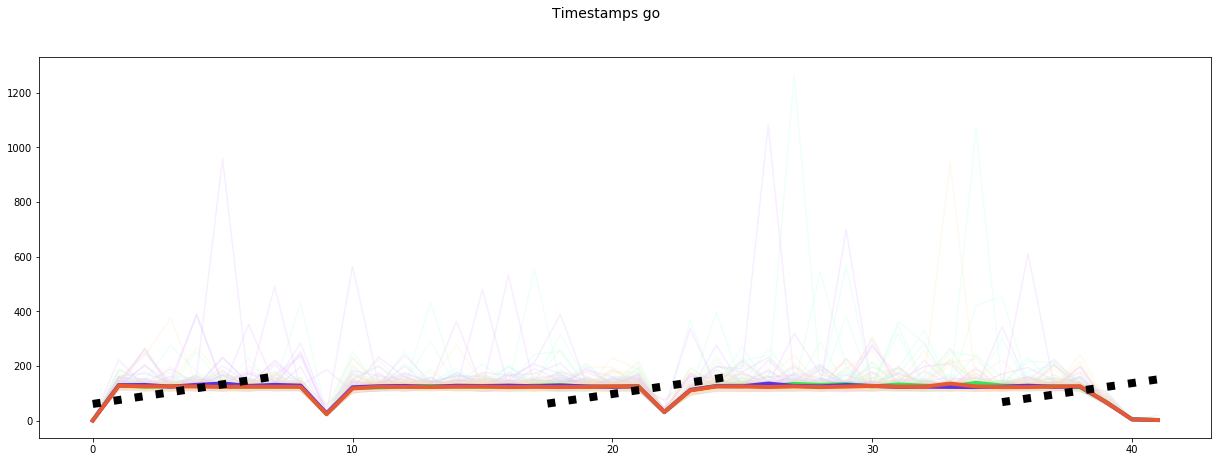

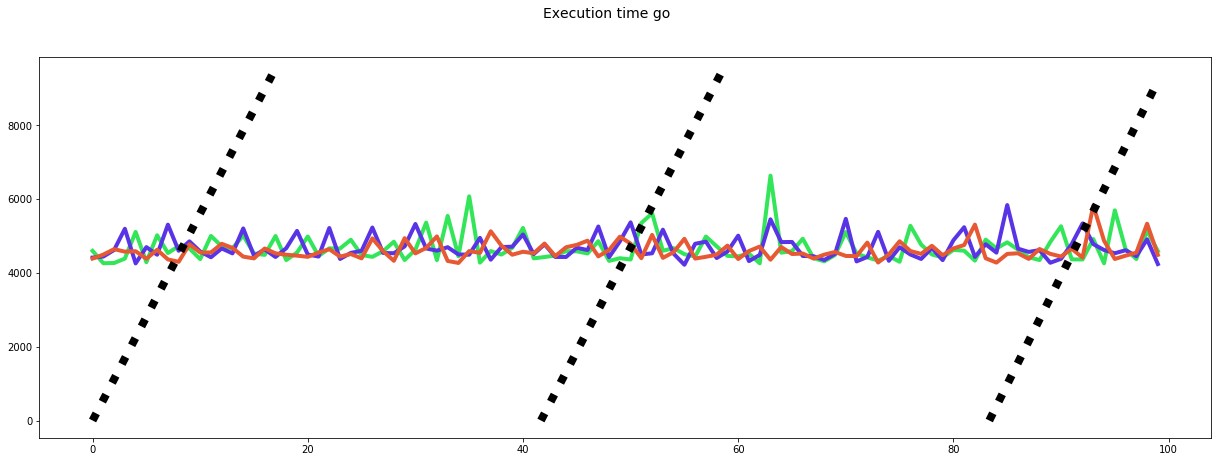

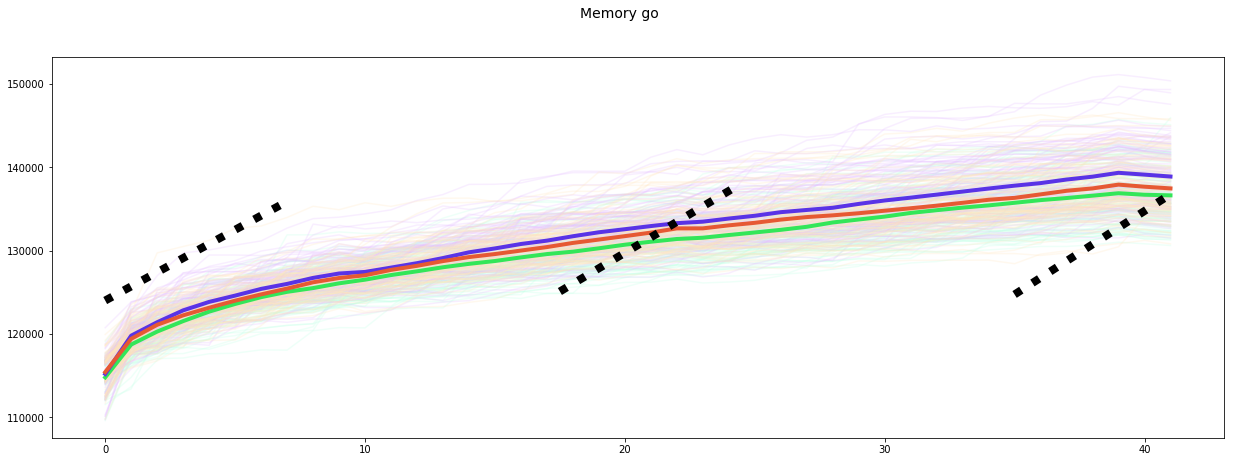

In [6]:
#FIXME: not the most efficient code ever...
for language in languages:    
    global fig_counter
    
    fig = plt.figure(fig_counter, figsize=(21,7))
    for mode in modes:
        ts, mem, t = allData(language, mode)
        plotTS(ts, language, mode)
    plt.show()  
    fig_counter = fig_counter + 1
    
    fig = plt.figure(fig_counter, figsize=(21,7))
    for mode in modes:
        ts, mem, t = allData(language, mode)
        plotT(t, language, mode)
    plt.show()  
    fig_counter = fig_counter + 1
    
    fig = plt.figure(fig_counter, figsize=(21,7))
    for mode in modes:
        ts, mem, t = allData(language, mode)
        plotMem(mem, language, mode)
    plt.show()  
    fig_counter = fig_counter + 1

In [45]:
def allModels(language, mode):
    if mode == 'base':
        directory = os.fsencode(models + '/' + language + '/nolog/')
    else:
        directory = os.fsencode(models + '/' + language + '/nolog/' + mode + '/')
    for file in os.listdir(directory):
        filename = os.path.abspath(directory + file)
        filename = str(filename).split("'")[1].replace("\\\\", "\\") #FIXME: dirty hack
        if filename.endswith('.thingml'): 
            if mode == 'base':
                for i in range(0,100):
                    yield filename
            else:
                yield filename
        
        
def allLoC(directory, ext, counter):
    for file in os.listdir(directory):        
        filename = os.path.abspath(directory + file)
        filename = str(filename).split("'")[1].replace("\\\\", "\\") #FIXME: dirty hack
        if filename.endswith(ext): 
            counter = counter + sum(1 for line in open(filename) if line.rstrip())
        elif os.path.isdir(filename):
            counter = counter + allLoC(os.fsencode(filename+"/"), ext, counter)            
    return counter
        
def loadLoThingML(filename):
    num_lines = sum(1 for line in open(filename) if line.rstrip())
    return num_lines

def plotLoThingML(t, language, mode):
    c = color(mode,1)
    fig.suptitle('Lines of ThingML ' + language, fontsize=14)
    plt.plot(t, color=c, linewidth=4, zorder=0)   
    
def plotLoC(t, language, mode):
    c = color(mode,1)
    fig.suptitle('Lines of Code ' + language, fontsize=14)
    plt.plot(t, color=c, linewidth=4, zorder=0)    

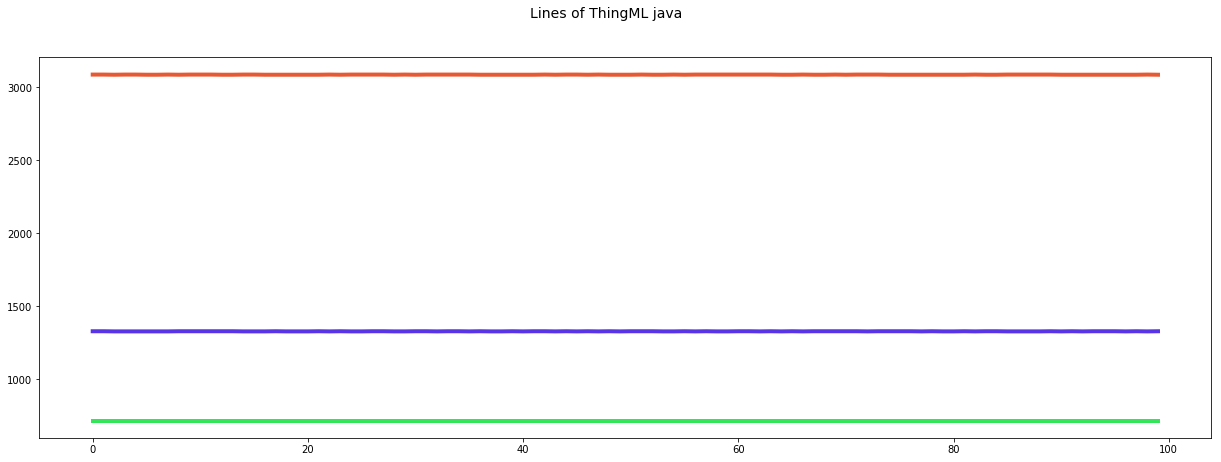

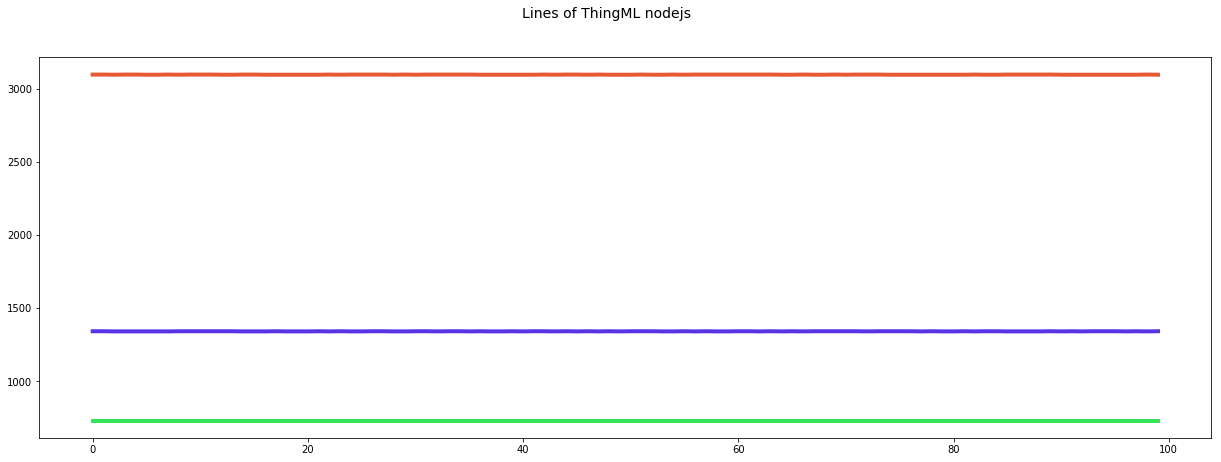

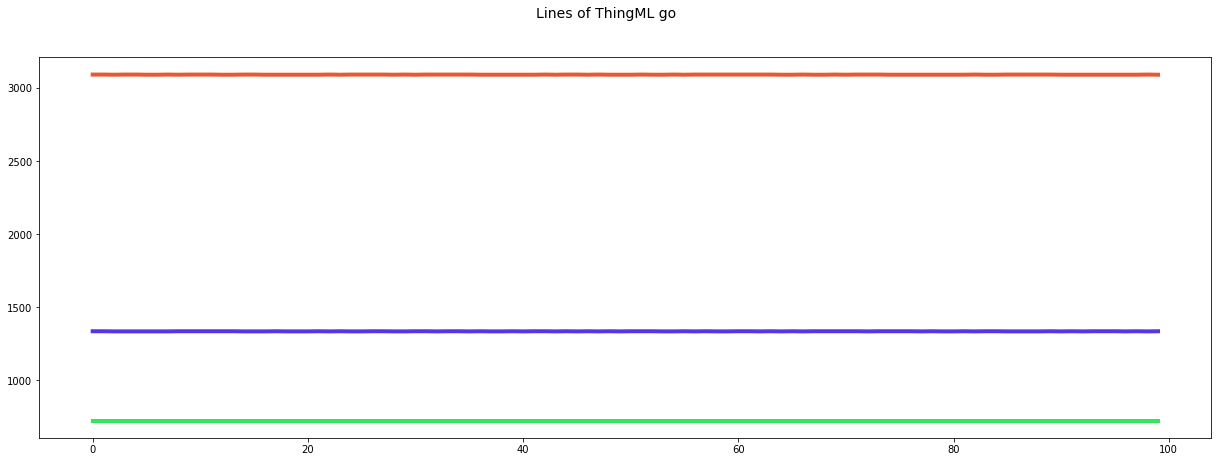

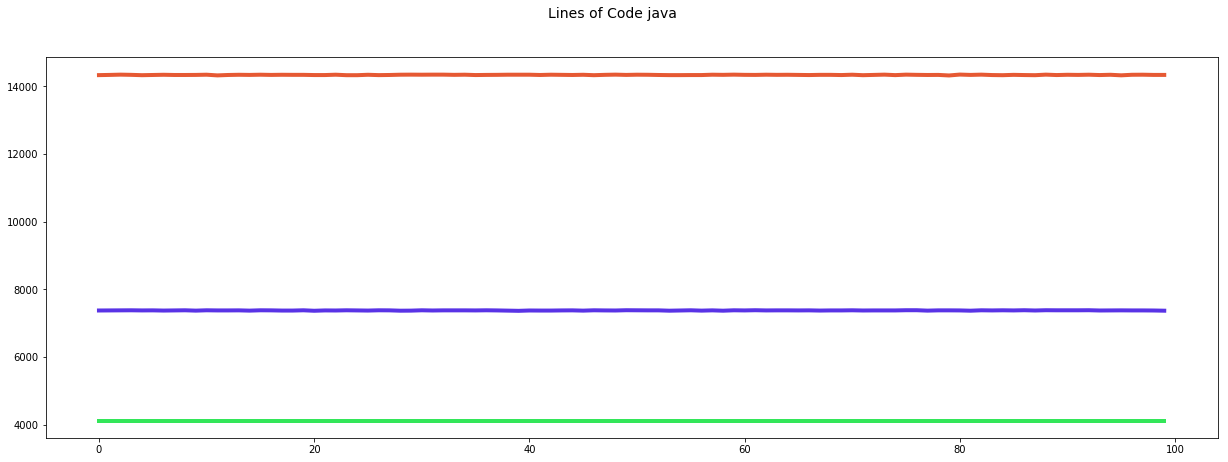

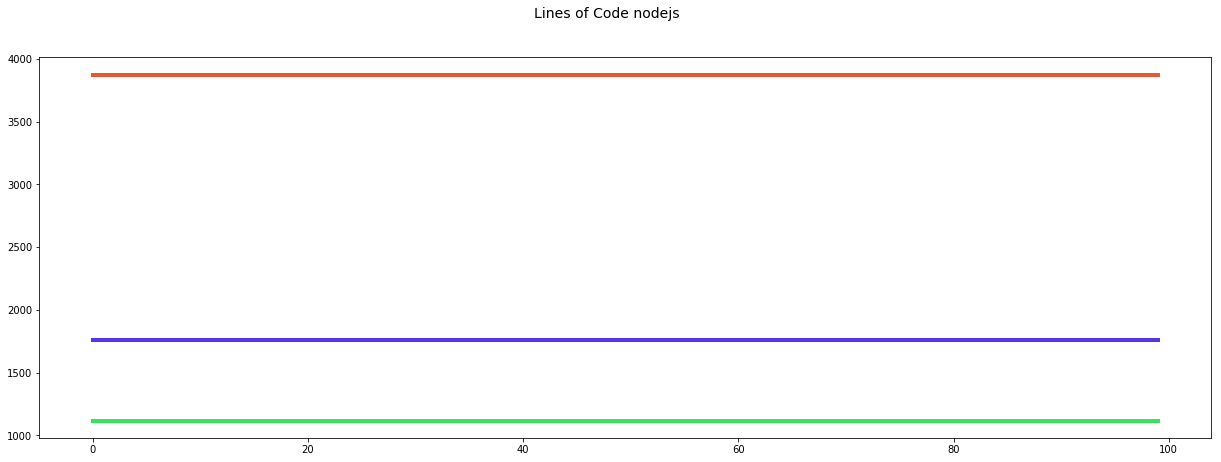

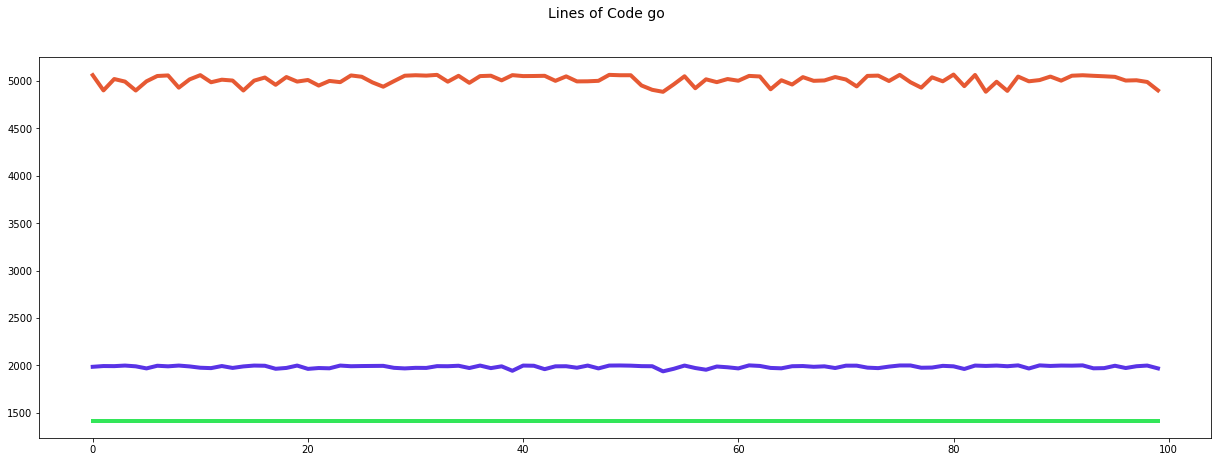

In [46]:
for language in languages:    
    global fig_counter    
    fig = plt.figure(fig_counter, figsize=(21,7))
    for mode in modes:
        lines = []
        for model in allModels(language, mode):            
            lines.append(loadLoThingML(model))
        plotLoThingML(lines, language, mode)
    plt.show()  
    fig_counter = fig_counter + 1
    
    
for language in languages:    
    global fig_counter       
    
    ext = ''
    if language == 'go':
        ext = '.go'
    elif language == 'java':
        ext = '.java'
    elif language == 'nodejs':
        ext = '.js'       
    
    fig = plt.figure(fig_counter, figsize=(21,7))
    for mode in modes:
        lines = []
        for i in range(0, 100): 
            directory = None
            if mode == 'base':
                directory = os.fsencode(sources + '/' + language + '/nolog/base/')
            else:
                directory = os.fsencode(sources + '/' + language + '/nolog/' + mode + '/' + language + str(i) + "/")                                     
            lines.append(allLoC(directory, ext, 0))
        plotLoC(lines, language, mode)
    plt.show()  
    fig_counter = fig_counter + 1        